# Evaluating Embeddings of Pragmatic Markers

### Load Model, Tokenizer

In [7]:
from transformers import BertModel, BertTokenizer

model_name = "bert-base-uncased"

model = BertModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)
MAX_TOKENS = 512

print("model:", model)
print("Tokenizer:", tokenizer)

/home/mwise/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


model: BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fa

# Generate Contextual Embeddings with Metadata:

In [15]:
import json
import h5py
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_contextual_embeddings_with_metadata(data, model, tokenizer):
    results = []
    for item in data:
        string = f'''"{item["previous_statement"]}" "{item["statement"]}"'''
        string = string.replace("<", "").replace(">", "")
        encoded_input = tokenizer(string, return_tensors='pt', truncation=True, max_length=512)
        output = model(**encoded_input)
        embeddings = output.last_hidden_state.detach().numpy()  # Shape: (batch_size, sequence_length, hidden_size)
        tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0])
        
        result = {
            'transcript_id': item['transcript_id'],
            'statement_id': item['statement_id'],
            'original_string': string,
            'tokens': tokens,
            'embeddings': embeddings[0],  # Keep as numpy array
            'matched_terms': item['matched_terms']
        }
        results.append(result)
    return results

import h5py
def save_to_hdf5(data, output_file = 'data/contextual_embeddings_with_metadata.h5'):
    with h5py.File(output_file, 'w') as f:
        for idx, item in enumerate(data):
            group = f.create_group(str(idx))
            group.create_dataset('transcript_id', data=item['transcript_id'])
            group.create_dataset('statement_id', data=item['statement_id'])
            group.create_dataset('original_string', data=item['original_string'])
            group.create_dataset('tokens', data=np.string_(item['tokens']))
            group.create_dataset('embeddings', data=item['embeddings'])
            group.create_dataset('matched_terms', data=np.string_(str(item['matched_terms'])))
    print(f"Data saved to {output_file}")

In [16]:
# # Generate Contextual Embeddings -- Uncomment to Re-Run
# with open('data/filtered_utterances_ft_data.json', 'r') as file:
#     data = json.load(file)
    
# data_use = data
# contextual_embeddings_with_metadata = get_contextual_embeddings_with_metadata(data_use, model, tokenizer)
# save_to_hdf5(contextual_embeddings_with_metadata)

Data saved to data/contextual_embeddings_with_metadata.h5


### Flag All Pragmatic Markers to Evaluate

In [17]:
import h5py
import json
from collections import Counter

# Load your JSON data
contextual_embeddings = 'data/contextual_embeddings_with_metadata.h5'
term_counts = {}

with h5py.File(contextual_embeddings, 'r') as f:
    # Iterate through each item in the HDF5 data
    for idx in f.keys():
        group = f[idx]
        matched_terms = eval(group['matched_terms'][()].decode('utf-8'))
        
        for term, value in matched_terms.items():
            if term not in term_counts:
                term_counts[term] = Counter()
            term_counts[term][value] += 1

# Output the results
for term, counts in term_counts.items():
    if len(counts) > 1:
        print(f"Term: {term}")
        for value, count in counts.items():
            print(f"  {value}: {count}")

Term: know
  hedge: 2
  none: 2
Term: believe
  hedge: 1
  none: 1
Term: sure
  none: 1
  hedge: 1
Term: tend
  hedge: 1
  none: 2


### Get all "Hedges", all "Authority", and all words that are flagged as 2+

In [4]:
import h5py
import numpy as np

# Read from HDF5
input_file = 'data/contextual_embeddings_with_metadata.h5'
with h5py.File(input_file, 'r') as f:
    for idx in f.keys():
        group = f[idx]
        transcript_id = group['transcript_id'][()]
        statement_id = group['statement_id'][()]
        original_string = group['original_string'][()].decode('utf-8')
        tokens = group['tokens'][()].astype(str).tolist()
        embeddings = group['embeddings'][()]
        matched_terms = eval(group['matched_terms'][()].decode('utf-8'))
        
        print(f"Transcript ID: {transcript_id}")
        print(f"Statement ID: {statement_id}")
        print(f"Original String: {original_string}")
        print(f"Tokens: {tokens}")
        print(f"Embedding Shape: {embeddings.shape}")
        print(f"Matched Terms: {matched_terms}")
        print()


Transcript ID: b'CNN-67617'
Statement ID: b'5e289e57-f0fb-4987-b912-4352761f8d56'
Original String: "Right. He can't read them all."
"Let's get away from the diplomatic wrangling here for a moment. Let's talk ABOUT the military front. Tommy Franks, head of the Central Command, yesterday at the Pentagon says the military is ready to go, is in position now, if GIVEN the order from the White House. To the Pentagon from yesterday, back again today, Barbara Starr for more on this -- Barbara, good morning to you. Turkey, we KNOW, not granting that permission to stage ABOUT 60,000 troops on its territory, which has the Pentagon scrambling right now. We are hearing that some movement, some aircraft carriers in the eastern Mediterranean COULD be on the move. What are we learning ABOUT this?"
Tokens: ['[CLS]', '"', 'right', '.', 'he', 'can', "'", 't', 'read', 'them', 'all', '.', '"', '"', 'let', "'", 's', 'get', 'away', 'from', 'the', 'diplomatic', 'wr', '##ang', '##ling', 'here', 'for', 'a', 'mo

In [4]:
# Define a function to get all hedges:
import h5py
import json
from util import get_category, get_dual_matches

# Load your JSON data
data = 'data/contextual_embeddings_with_metadata.h5'

# Get all items where value is "hedge"
hedge_items = get_category(data, "hedge")
# for item in hedge_items[:10]:
#     print(item['matched_terms'])
    
authority_items = get_category(data, "authority")
# for item in authority_items[:10]:
#     print(item['matched_terms'])
dual_items = get_dual_matches(data)
for item in hedge_items[1]:
    print(item)

Category: hedge - 32 sample sentences found.
Category: authority - 6 sample sentences found.
transcript_id
statement_id
original_string
tokens
embeddings
matched_terms


In [5]:
data_path = 'data/contextual_embeddings_with_metadata.h5'
import h5py

def get_h5py_data(data):
    samples = []
    with h5py.File(data, 'r') as f:
        for idx in f.keys():
            group = f[idx]
            matched_terms = eval(group['matched_terms'][()].decode('utf-8'))
            hedge_terms = {term: value for term, value in matched_terms.items() if value == "hedge"}
            if hedge_terms:
                hedged_item = {
                    'transcript_id': group['transcript_id'][()],
                    'statement_id': group['statement_id'][()],
                    'original_string': group['original_string'][()].decode('utf-8'),
                    'tokens': group['tokens'][()].astype(str).tolist(),
                    'embeddings': group['embeddings'][()],
                    'matched_terms': hedge_terms
                }
                samples.append(hedged_item)
    return samples
data = get_h5py_data(data_path)

In [8]:
from util import get_category_vectors
MAX_TOKENS = 512
hedge_vectors_tuples = get_category_vectors(hedge_items, "hedge", model=model, tokenizer=tokenizer, max_tokens=MAX_TOKENS) 
authority_vectors_tuples = get_category_vectors(authority_items, "authority", model=model, tokenizer=tokenizer, max_tokens=MAX_TOKENS)
print("Vector Shapes:", hedge_vectors_tuples[0][0].shape)
print("Hedge Vectors:", len(hedge_vectors_tuples))
print("Authority Vectors:", len(authority_vectors_tuples))

Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors


Vector Shapes: torch.Size([768])
Hedge Vectors: 57
Authority Vectors: 7


### Identify Similar Parts of Hedge, Authority Words

In [9]:
from util import identify_similar_parts, extract_vectors_from_tuples
threshold = 0.7

# Extract vectors from the tuples
hedge_vectors = extract_vectors_from_tuples(hedge_vectors_tuples)
authority_vectors = extract_vectors_from_tuples(authority_vectors_tuples)

# Identify similar parts for hedge vectors
similar_dimensions_hedge, dimension_similarities_hedge = identify_similar_parts(hedge_vectors)
print("Similar dimensions (hedge):", len(similar_dimensions_hedge))
# Identify similar parts for authority vectors
similar_dimensions_authority, dimension_similarities_authority = identify_similar_parts(authority_vectors)
print("Similar dimensions (authority):", len(similar_dimensions_authority))

Similar dimensions (hedge): 68
Similar dimensions (authority): 172


In [10]:
for item in hedge_vectors_tuples[:3]:
    print(item[1], item[2])

could hedge
allegedly hedge
know hedge


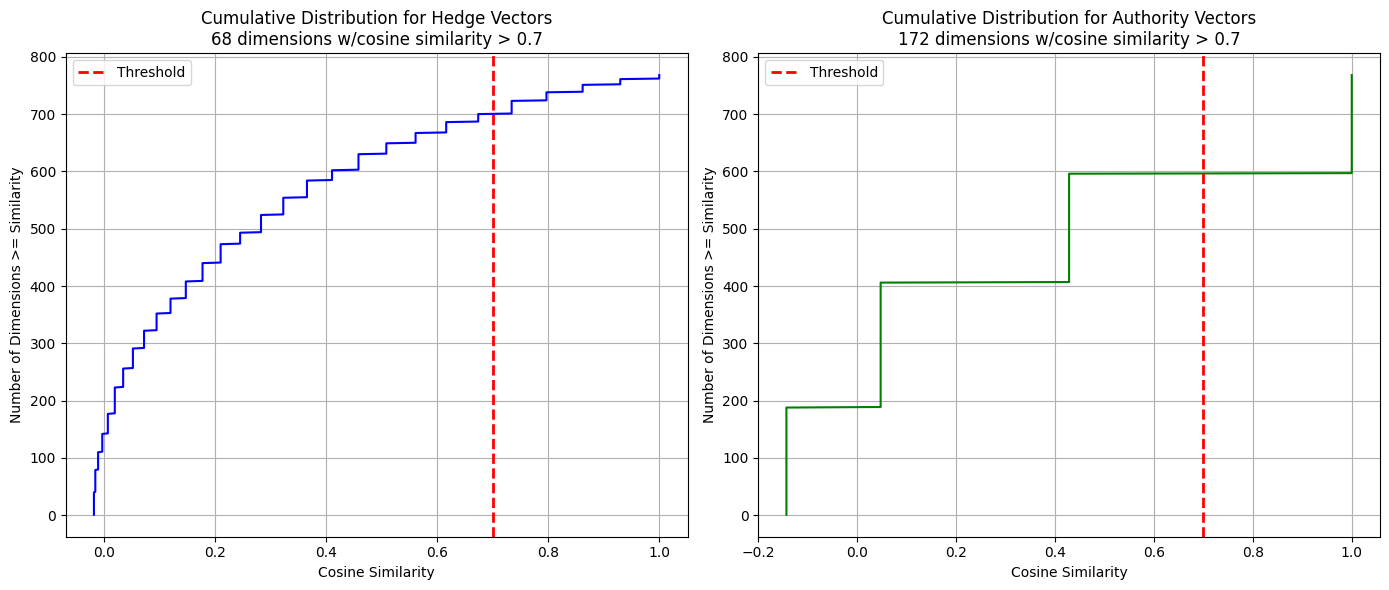

In [11]:
import matplotlib.pyplot as plt
from util_plotting import plot_cumulative_distribution

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot cumulative distribution for hedge vectors
plt.sca(axes[0])
plot_cumulative_distribution(dimension_similarities_hedge, 'Cumulative Distribution for Hedge Vectors', 'blue', threshold)

# Plot cumulative distribution for authority vectors
plt.sca(axes[1])
plot_cumulative_distribution(dimension_similarities_authority, 'Cumulative Distribution for Authority Vectors', 'green', threshold)

plt.tight_layout()
plt.show()

In [21]:
import numpy as np
from scipy.spatial.distance import cosine

def find_similar_ngrams(example, hedge_vectors, similar_dimensions, n=3, threshold=0.75):
    example_tokens = example['tokens']
    example_embeddings = example['embeddings']
    example_id = example['statement_id']
    similar_ngrams = []
    
    # Extract the embeddings for the similar dimensions
    example_embeddings_reduced = example_embeddings[:, similar_dimensions]
    
    def n_grams(tokens, embeddings, n):
        """Generate n-grams and their corresponding average embeddings."""
        for i in range(len(tokens) - n + 1):
            yield tokens[i:i+n], np.mean(embeddings[i:i+n], axis=0)
    
    for tokens, avg_embedding in n_grams(example_tokens, example_embeddings_reduced, n):
        similarity = 0
        for hedge_vector in hedge_vectors:
            hedge_vector_reduced = hedge_vector[similar_dimensions]
            similarity += (1 - cosine(avg_embedding, hedge_vector_reduced))
        if (similarity / len(hedge_vectors)) > threshold:
            similar_ngrams.append(" ".join(tokens))
    
    return similar_ngrams

# Example usage
threshold = 0.85

for example in data:
    # print(example['original_string'])
    similar_words = find_similar_ngrams(example, hedge_vectors, similar_dimensions_hedge, n = 1, threshold=threshold)
    if len(similar_words) > 0:
        print(similar_words)

['maybe']


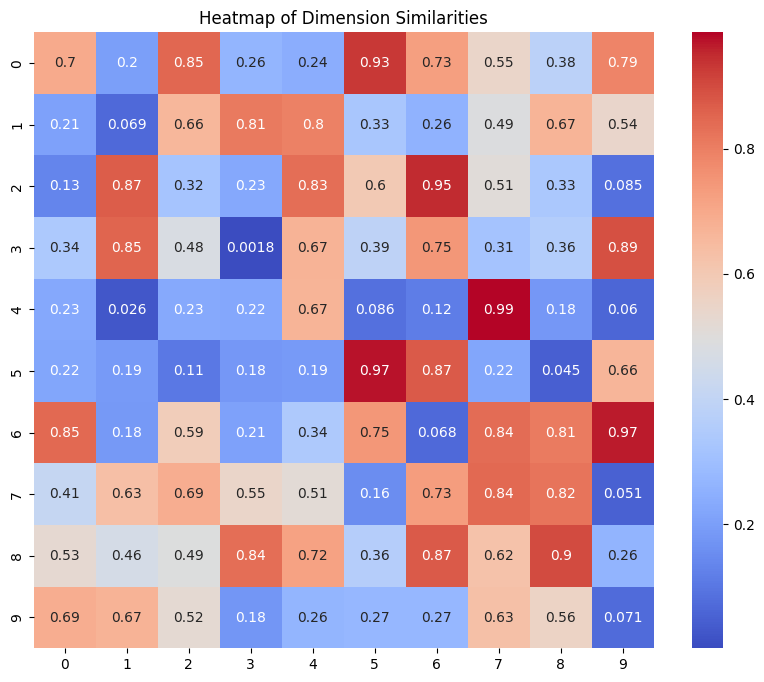

In [ ]:
import seaborn as sns

# Generate a random similarity matrix for demonstration purposes
similarity_matrix = np.random.rand(10, 10)

# Plot a heatmap of the similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap='coolwarm', annot=True)
plt.title('Heatmap of Dimension Similarities')
plt.show()

In [ ]:
import json

# Load your JSON data
with open('data/filtered_utterances_ft_data.json', 'r') as file:
    data = json.load(file)

word = "know"
# Filter data to include entries where 'matched_terms' has 'know' as a key
filtered_data = [item for item in data if word in item['matched_terms']]
statements = []
# Optionally, print the filtered data to see the result
for item in filtered_data:
    # Concatenate strings properly
    string = item["previous_statement"] + " statement: " + item["statement"]
    category = item["matched_terms"]["know"]
    # Remove '<' and '>' characters from the string
    string = string.replace("<", "")
    string = string.replace(">", "")
    statements.append((string, category, word))
for item in statements:
    print(item)

("You know, Salena, as someone who covers the president's base so extensively and so well, answer this for us. Release the memo has become a battle cry for many in the president's base and for many in the right wing. Is there any way that the president does not, cannot release the memo at this point in time, despite the pleas of his own handpicked FBI chief not to do so? Is he stuck? statement: You KNOW, I don't -- I -- because he's such a different KIND OF president and he navigates the presidency in a way, you KNOW, that's not ALWAYS predictable, I mean I COULD see a scenario where, you KNOW, he says, OK, Wray, let's sit down and talk ABOUT this. You KNOW, what's he -- what are the things that you find that are dangerous or COULD put people in jeopardy? What SHOULD we redact? Then I'll release the memo. I mean there is the possibility that that happens. I don't THINK there's any political -- not any. There's ALWAYS some, right? But I don't THINK there's a large political problem if t

In [ ]:
import numpy as np

def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

def identify_similar_parts(vectors, threshold=0.5):
    num_vectors = len(vectors)
    num_dimensions = len(vectors[0])
    
    # Initialize a list to hold the similarity for each dimension
    dimension_similarities = np.zeros(num_dimensions)
    
    # Compute the cosine similarity for each dimension across all pairs of vectors
    for i in range(num_vectors):
        for j in range(i + 1, num_vectors):
            vec1, vec2 = vectors[i], vectors[j]
            for k in range(num_dimensions):
                dim_vec1 = np.zeros(num_dimensions)
                dim_vec2 = np.zeros(num_dimensions)
                dim_vec1[k] = vec1[k]
                dim_vec2[k] = vec2[k]
                dimension_similarities[k] += cosine_similarity(dim_vec1, dim_vec2)
    
    # Average the similarity scores for each dimension
    dimension_similarities /= (num_vectors * (num_vectors - 1) / 2)
    
    # Identify dimensions with similarity above the threshold
    similar_dimensions = np.where(dimension_similarities > threshold)[0]
    
    return similar_dimensions, dimension_similarities

In [ ]:
from transformers import BertModel, BertTokenizer
import torch
from scipy.spatial.distance import cosine

# Load the pretrained BERT base uncased model and tokenizer
model_name = "bert-base-uncased"
model = BertModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

vectors = []
for statement in statements:
    sample_text = statement[0]
    classification = statement[1]
    word = statement[2]
    # Encode the text
    encoded_input = tokenizer(sample_text, return_tensors='pt')

    # Extract input ids and find the indices for "know"
    input_ids = encoded_input['input_ids'][0]
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    token_indices = [i for i, token in enumerate(tokens) if token == 'know']

    # Get the model output
    output = model(**encoded_input)

    # Extract embeddings for "know"
    token_embeddings = output.last_hidden_state[0, token_indices, :] if token_indices else None
    if token_embeddings is not None:
        vectors.append((token_embeddings.mean(dim=0).detach(),classification, word))  # Average if multiple "know" tokens and detach
    else:
        vectors.append((None, None, None))  # No "know" found in this sample

# Compute cosine similarity between all pairs of vectors
if len(vectors) > 1:
    for i in range(len(vectors)):
        for j in range(i + 1, len(vectors)):
            if vectors[i] is not None and vectors[j] is not None:
                cat1 = vectors[i][1]
                cat2 = vectors[j][1]
                word = vectors[i][2]
                similarity = 1 - cosine(vectors[i][0].numpy(), vectors[j][0].numpy())
                print(f"{word} {i+1},{j+1}: {cat1}/{cat2} Cosine similarity: {similarity:.4f}")
            else:
                print(f"One or both of the texts {i+1} and {j+1} do not contain the token 'know'.")

know 1,2: hedge/hedge Cosine similarity: 0.8926
know 1,3: hedge/none Cosine similarity: 0.7740
know 1,4: hedge/none Cosine similarity: 0.3465
know 2,3: hedge/none Cosine similarity: 0.8332
know 2,4: hedge/none Cosine similarity: 0.4173
know 3,4: none/none Cosine similarity: 0.3577


In [ ]:
0.8926
0.7740
0.3465
0.8332
0.4173
0.3577